# Here we fit logistic function to Alberta coronavirus cases.
# Install jupyter and ipywidgets from anaconda prompt as below:
## conda install -c conda-forge jupyter ipywidgets


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit#,root,fsolve
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error as mse
%matplotlib notebook


from ipywidgets import Button, FloatSlider,HBox


<IPython.core.display.Javascript object>


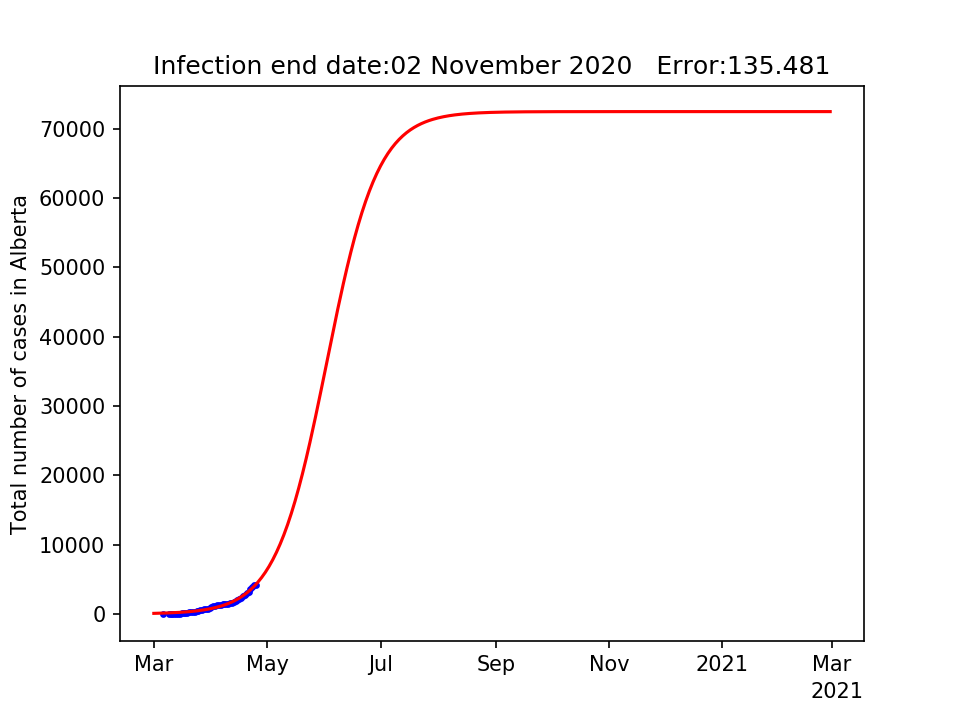

In [2]:
df=pd.read_csv(r"C:\Users\koushb\Downloads\covid19dataexport.csv",index_col=0)
df["Date reported"]=pd.to_datetime(df['Date reported'])
basedate=pd.Timestamp("2020-03-1")
df['time since']=(df['Date reported']-basedate).dt.days

table1=pd.pivot_table(df,values='Gender',index=['Date reported','time since'],aggfunc=np.size)
table1['cumsum']=table1['Gender'].cumsum()
table1.reset_index(inplace=True)
table1.drop('Gender',axis=1,inplace=True)


x=table1['time since']
y=table1['cumsum']

ndays=365

def myfunc(x,a,b,c):
    r=c/(1+np.exp(-(x-b)/a))
    return(r)

def autofit():
    
    fit=curve_fit(myfunc,x,y,p0=[20,40,2500])
    a,b,c=fit[0]
    a_value.value=a
    b_value.value=b
    c_value.value=c
    #print(a,b,c)
    
    return(a,b,c)

def autofit_clicked(change=None):
    autofit()
    plotit()
    


def cal_sol(a,b,c):
    for sol in range(ndays):
        r=int(c)-myfunc(sol,a,b,c)
        if r<1:
            break
    endday=basedate+pd.DateOffset(days=sol)
    return(endday)
fig,ax=plt.subplots(1)

def plotit(change=None):
    ax.cla()
    a=a_value.value
    b=b_value.value
    c=c_value.value
    endday=cal_sol(a,b,c)
    y_pred=myfunc(x,a,b,c)
    err=np.sqrt(mse(y,y_pred))
    xx=np.arange(ndays)
    yy=myfunc(xx,a,b,c)

    r=[]
    for i in range(ndays):
        r.append(basedate+pd.DateOffset(days=i))



    a_r=np.array([r,yy]).T
    df_pred=pd.DataFrame(a_r,columns=['Date reported','prediction'])


    df_total=pd.merge(df_pred,table1,on='Date reported',how='left')


    
    ax.plot(df_total['Date reported'],df_total['prediction'],c='r')
    ax.scatter(df_total['Date reported'],df_total['cumsum'],s=5,c='b')
    locator = mdates.AutoDateLocator()
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    plt.ylabel('Total number of cases in Alberta')
    plt.title('Infection end date:'+endday.strftime("%d %B %Y")+'   Error:'+str(np.round(err,3)))
    plt.show()

    
a_value=FloatSlider(value=7.5,min=0,max=20.0,step=0.1,description='a:',disabled=False,continuous_update=False,
            orientation='horizontal',
            readout=True,
            readout_format='.1f',
            style={'description_width': 'initial'}
)
b_value=FloatSlider(value=7.5,min=0,max=100.0,step=1,description='b:',disabled=False,continuous_update=False,
            orientation='horizontal',
            readout=True,
            readout_format='.1f',
            style={'description_width': 'initial'}
)
c_value=FloatSlider(value=7.5,min=0,max=100000.0,step=1,description='c:',disabled=False,continuous_update=False,
            orientation='horizontal',
            readout=True,
            readout_format='.1f',
            style={'description_width': 'initial'}
)
AF=Button(description='Auto Fit')
h1=HBox([a_value,b_value,c_value,AF])

a_value.observe(plotit, names=['value'])    
b_value.observe(plotit, names=['value'])
c_value.observe(plotit, names=['value'])

AF.on_click(autofit_clicked)
autofit()
plotit()

display(h1)